In [1]:
import re
import math
import pandas as pd
import ast


In [2]:
import re
import math

def extract_tensor_values(sparsities_str):
    tensor_strings = sparsities_str.strip('()').split('), ')
    values = []
    for tensor_str in tensor_strings:
        match = re.search(r"tensor\(([\d.]+)", tensor_str)
        if match:
            values.append(float(match.group(1)))
    return values

# def get_linear_bops(in_features, out_features, sparsity, bit_width):
#     effective_connections = in_features * out_features * (1 - sparsity)
#     mult_bops = effective_connections * bit_width * bit_width
#     add_bops = effective_connections * (2 * bit_width + math.ceil(math.log2(in_features)))
#     return mult_bops + add_bops

def get_linear_bops(in_features, out_features, sparsity, bit_width=32):
    return out_features * in_features * (1 - sparsity) * (
         bit_width**2 + 2*bit_width + math.log2(in_features)
        
    )

def calculate_model_bops(model_name, phi_sparsities, rho_sparsities, bit_width):
    model_architectures = {
        'Large': {
            'phi': [(3, 32), (32, 32)],
            'rho': [(32, 32), (32, 64), (64, 5)]
        },
        'Medium': {
            'phi': [(3, 32), (32, 16)],
            'rho': [(16, 64), (64, 8), (8, 32), (32, 5)]
        },
        'Small': {
            'phi': [(3, 8), (8, 8)],
            'rho': [(8, 16), (16, 16), (16, 5)]
        },
        'Tiny': {
            'phi': [(3, 16)],
            'rho': [(16, 8), (8, 8), (8, 4), (4, 5)]
        }
    }

    architecture = model_architectures[model_name]
    total_bops = 0

    for (in_features, out_features), sparsity in zip(architecture['phi'], phi_sparsities):
        total_bops += get_linear_bops(in_features, out_features, sparsity, bit_width)

    for (in_features, out_features), sparsity in zip(architecture['rho'], rho_sparsities):
        total_bops += get_linear_bops(in_features, out_features, sparsity, bit_width)

    return total_bops

def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {}
    for line in lines:
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model Prune Iter: (\d+)", line)
        if match:
            model_name, bit_width, iteration = match.groups()
            full_model_name = f"Deepsets {model_name} Model {bit_width}-Bit QAT Model"
            
            if full_model_name not in data:
                data[full_model_name] = {
                    'model_name': [],
                    'bit_width': [],
                    'iteration': [],
                    'test_accuracy': [],
                    'val_accuracy': [],
                    'val_loss': [],
                    'phi_sparsities': [],
                    'rho_sparsities': [],
                    'total_bops': [],
                    'net sparsity': []
                }
            
            test_accuracy = float(re.search(r"Test Accuracy: ([\d.]+)", line).group(1))
            val_accuracy = float(re.search(r"Val Accuracy: ([\d.]+)", line).group(1))
            val_loss = float(re.search(r"Val Loss: ([\d.]+)", line).group(1))
            
            phi_sparsities_str = re.search(r"Phi Sparsities: (.*?) Rho Sparsities:", line).group(1)
            rho_sparsities_str = re.search(r"Rho Sparsities: (.*?)$", line).group(1)

            phi_sparsities = extract_tensor_values(phi_sparsities_str)
            rho_sparsities = extract_tensor_values(rho_sparsities_str)

            # Calculate BOPs
            total_bops = calculate_model_bops(model_name, phi_sparsities, rho_sparsities, int(bit_width))

            net_sparsity = 1- 0.8**int(iteration)

            # Append data to the respective lists
            data[full_model_name]['model_name'].append(model_name)
            data[full_model_name]['bit_width'].append(int(bit_width))
            data[full_model_name]['iteration'].append(int(iteration))
            data[full_model_name]['test_accuracy'].append(test_accuracy)
            data[full_model_name]['val_accuracy'].append(val_accuracy)
            data[full_model_name]['val_loss'].append(val_loss)
            data[full_model_name]['phi_sparsities'].append(phi_sparsities)
            data[full_model_name]['rho_sparsities'].append(rho_sparsities)
            data[full_model_name]['total_bops'].append(total_bops)

            data[full_model_name]['net sparsity'].append(net_sparsity)
            # print("phi_sparsities:", phi_sparsities, "rho_sparsities:", rho_sparsities)

            print(f"model name: {model_name}, total_bops: {total_bops:.2e}, net sparsity: {net_sparsity:.4f}, bit width: {bit_width}")

    return data


# file_path = '/Users/dimademler/Downloads/NAC_Compress2.txt'
# file_path = '/Users/dimademler/Downloads/combined_deepsets_Compress4.txt'
file_path = './combined_deepsets_Compress_Aug7.txt'
extracted_data = extract_data(file_path)



model name: Large, total_bops: 4.93e+06, net sparsity: 0.0000, bit width: 32
model name: Large, total_bops: 3.95e+06, net sparsity: 0.2000, bit width: 32
model name: Large, total_bops: 3.16e+06, net sparsity: 0.3600, bit width: 32
model name: Large, total_bops: 2.52e+06, net sparsity: 0.4880, bit width: 32
model name: Large, total_bops: 2.02e+06, net sparsity: 0.5904, bit width: 32
model name: Large, total_bops: 1.62e+06, net sparsity: 0.6723, bit width: 32
model name: Large, total_bops: 1.29e+06, net sparsity: 0.7379, bit width: 32
model name: Large, total_bops: 1.03e+06, net sparsity: 0.7903, bit width: 32
model name: Large, total_bops: 8.27e+05, net sparsity: 0.8322, bit width: 32
model name: Large, total_bops: 6.62e+05, net sparsity: 0.8658, bit width: 32
model name: Large, total_bops: 5.30e+05, net sparsity: 0.8926, bit width: 32
model name: Large, total_bops: 4.24e+05, net sparsity: 0.9141, bit width: 32
model name: Large, total_bops: 3.39e+05, net sparsity: 0.9313, bit width: 32

In [3]:
# print(4.93e+06/7.11e+04)
print(4.93e6/7.11e4)
print(1/(1-0.9856))

def bop_to_sparsity_ratio(model_name,data):
    model = data[model_name]
    first_BOP = model['total_bops'][0]
    last_BOP = model['total_bops'][-1]
    last_sparsity = model['net sparsity'][-1]
    # print(f'first bop: {first_BOP:.2e}, last bop: {last_BOP:.2e}, last sparsity: {last_sparsity:.4f}')

    BOP_ratio = first_BOP/last_BOP
    sparsity_ratio = 1/(1-last_sparsity)

    print(f"for {model_name} BOPs decrease by a factor of {BOP_ratio:.4f} and sparsity increases by a factor of {sparsity_ratio:.4f}")

    # print(f"Model: {model_name}, BOP Ratio: {BOP_ratio:.4f}, Sparsity Ratio: {sparsity_ratio:.4f}")

large_model32= 'Deepsets Large Model 32-Bit QAT Model'
large_model8= 'Deepsets Large Model 8-Bit QAT Model'
medium_model32= 'Deepsets Medium Model 32-Bit QAT Model'
medium_model4= 'Deepsets Medium Model 4-Bit QAT Model'
small_model32= 'Deepsets Small Model 32-Bit QAT Model'
small_model16= 'Deepsets Small Model 16-Bit QAT Model'

bop_to_sparsity_ratio(large_model32,extracted_data)
bop_to_sparsity_ratio(large_model8,extracted_data)
bop_to_sparsity_ratio(medium_model32,extracted_data)
bop_to_sparsity_ratio(medium_model4,extracted_data)
bop_to_sparsity_ratio(small_model32,extracted_data)
bop_to_sparsity_ratio(small_model16,extracted_data)



# # print(extracted_data.keys())
# large_model = extracted_data['Deepsets Large Model 32-Bit QAT Model']
# # large_model = extracted_data['Deepsets Small Model 32-Bit QAT Model']
# print(large_model.keys())
# for bit, phi_sparsity, rho_sparsity, total_bops, net_sparsity in zip(large_model['bit_width'], large_model['phi_sparsities'], large_model['rho_sparsities'], large_model['total_bops'], large_model['net sparsity']):
#     print(f"Bit Width: {bit}, Phi Sparsity: {phi_sparsity}, Rho Sparsity: {rho_sparsity}, Total BOPs: {total_bops:.2e} net sparsity: {net_sparsity:.4f}")

# BOP_ratio = 3.95e+06/7.12e+04
# sparsity_ratio = 1/(1-0.9856)
# print(BOP_ratio, sparsity_ratio)

# BOP_ratiosmall = 6.03e+05/8.72e+03
# sparsity_ratiosmall = 1/(1-0.9856)
# print(BOP_ratiosmall, sparsity_ratiosmall)

69.33895921237693
69.4444444444446
for Deepsets Large Model 32-Bit QAT Model BOPs decrease by a factor of 69.3820 and sparsity increases by a factor of 69.3889
for Deepsets Large Model 8-Bit QAT Model BOPs decrease by a factor of 70.5487 and sparsity increases by a factor of 69.3889
for Deepsets Medium Model 32-Bit QAT Model BOPs decrease by a factor of 69.1954 and sparsity increases by a factor of 69.3889
for Deepsets Medium Model 4-Bit QAT Model BOPs decrease by a factor of 73.5723 and sparsity increases by a factor of 69.3889
for Deepsets Small Model 32-Bit QAT Model BOPs decrease by a factor of 69.0523 and sparsity increases by a factor of 69.3889
for Deepsets Small Model 16-Bit QAT Model BOPs decrease by a factor of 69.1594 and sparsity increases by a factor of 69.3889


model name: Large, total_bops: 4.93e+06, net sparsity: 0.0000, bit width: 32
model name: Large, total_bops: 3.95e+06, net sparsity: 0.2000, bit width: 32
model name: Large, total_bops: 3.16e+06, net sparsity: 0.3600, bit width: 32
model name: Large, total_bops: 2.52e+06, net sparsity: 0.4880, bit width: 32
model name: Large, total_bops: 2.02e+06, net sparsity: 0.5904, bit width: 32
model name: Large, total_bops: 1.62e+06, net sparsity: 0.6723, bit width: 32
model name: Large, total_bops: 1.29e+06, net sparsity: 0.7379, bit width: 32
model name: Large, total_bops: 1.03e+06, net sparsity: 0.7903, bit width: 32
model name: Large, total_bops: 8.27e+05, net sparsity: 0.8322, bit width: 32
model name: Large, total_bops: 6.62e+05, net sparsity: 0.8658, bit width: 32
model name: Large, total_bops: 5.30e+05, net sparsity: 0.8926, bit width: 32
model name: Large, total_bops: 4.24e+05, net sparsity: 0.9141, bit width: 32
model name: Large, total_bops: 3.39e+05, net sparsity: 0.9313, bit width: 32

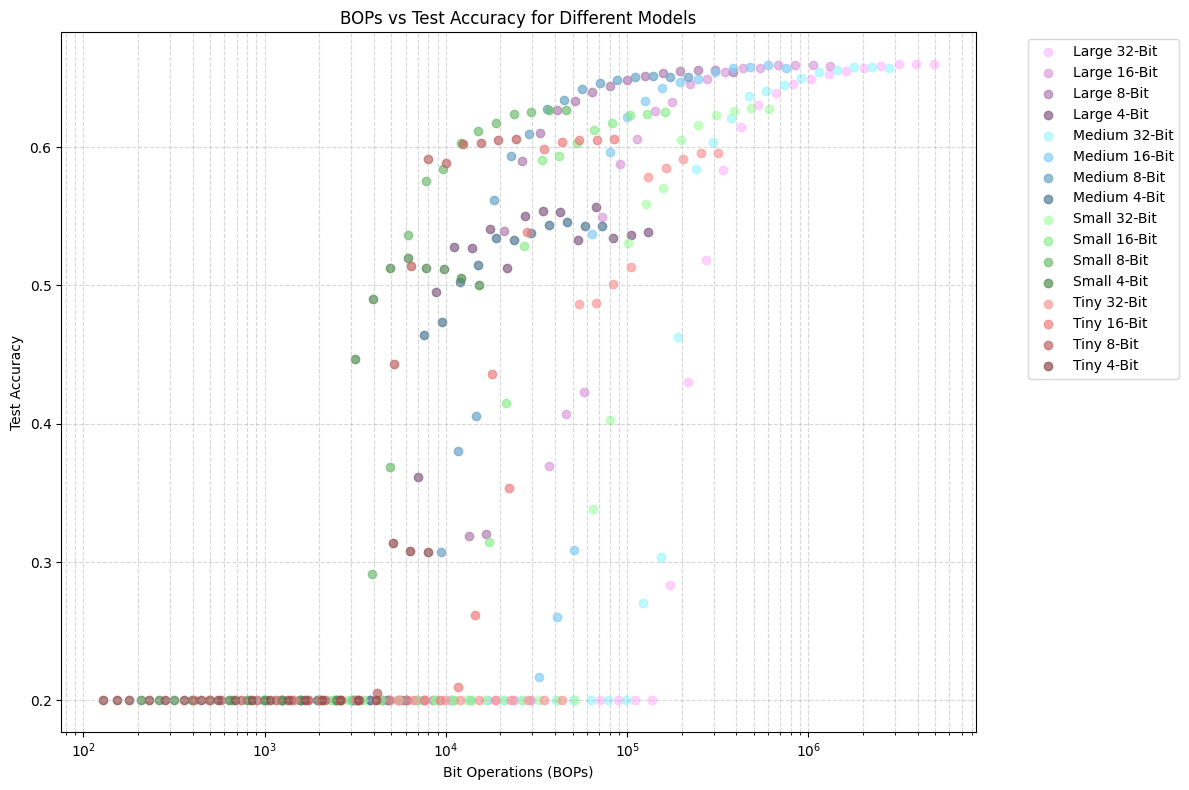

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def plot_bops_vs_accuracy(data, output_folder='./plots'):
    plt.figure(figsize=(12, 8))
    
    # Define the order of models from smallest to largest
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }

    # Define shade adjustments for different bit widths
    bit_width_shades = {
        4: 0.6,  # Darker
        8: 0.8,
        16: 1.0,  # OG color
        32: 1.2  # Lighter
    }

    for full_model_name, model_data in data.items():
        # Extract model size and bit width from the full model name
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model", full_model_name)
        if match:
            model_size, bit_width = match.groups()
            bit_width = int(bit_width)

            if model_size in model_order:
                model_name = f'{model_size} {bit_width}-Bit'
                
                # Adjust color based on bit width
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                            label=model_name, 
                            alpha=0.7, 
                            color=adjusted_color)

    plt.xscale('log') 
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(f'{output_folder}/BOPs_vs_Accuracy_colored.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_folder}/BOPs_vs_Accuracy_colored.png")
    
    plt.show()

extracted_data = extract_data(file_path)
plot_bops_vs_accuracy(extracted_data)

model name: Large, total_bops: 4.93e+06, net sparsity: 0.0000, bit width: 32
model name: Large, total_bops: 3.95e+06, net sparsity: 0.2000, bit width: 32
model name: Large, total_bops: 3.16e+06, net sparsity: 0.3600, bit width: 32
model name: Large, total_bops: 2.52e+06, net sparsity: 0.4880, bit width: 32
model name: Large, total_bops: 2.02e+06, net sparsity: 0.5904, bit width: 32
model name: Large, total_bops: 1.62e+06, net sparsity: 0.6723, bit width: 32
model name: Large, total_bops: 1.29e+06, net sparsity: 0.7379, bit width: 32
model name: Large, total_bops: 1.03e+06, net sparsity: 0.7903, bit width: 32
model name: Large, total_bops: 8.27e+05, net sparsity: 0.8322, bit width: 32
model name: Large, total_bops: 6.62e+05, net sparsity: 0.8658, bit width: 32
model name: Large, total_bops: 5.30e+05, net sparsity: 0.8926, bit width: 32
model name: Large, total_bops: 4.24e+05, net sparsity: 0.9141, bit width: 32
model name: Large, total_bops: 3.39e+05, net sparsity: 0.9313, bit width: 32

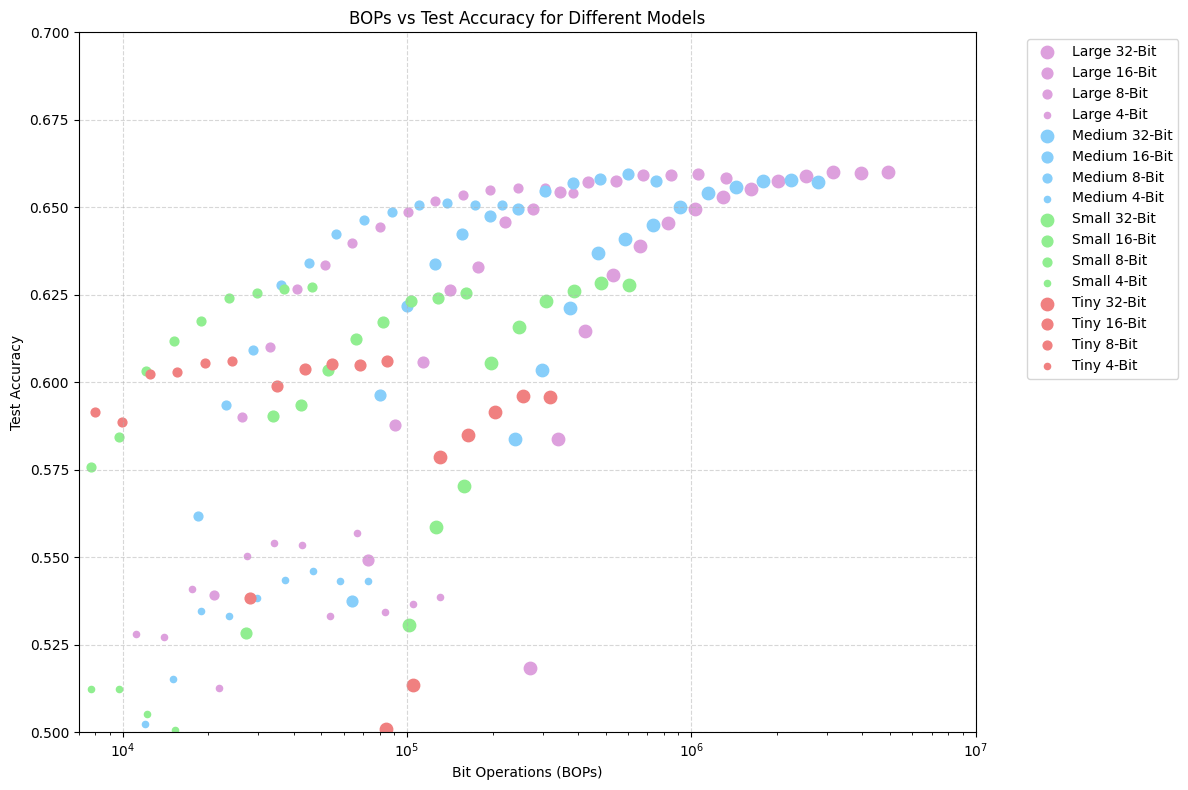

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def plot_bops_vs_accuracy(data, output_folder='./plots'):
    plt.figure(figsize=(12, 8))
    
    # Define the order of models from smallest to largest
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }

    # Define sizes for different bit widths
    bit_width_sizes = {
        4: 20,
        8: 40,
        16: 60,
        32: 80
    }

    for full_model_name, model_data in data.items():
        # Extract model size and bit width from the full model name
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model", full_model_name)
        if match:
            model_size, bit_width = match.groups()
            bit_width = int(bit_width)

            if model_size in model_order:
                model_name = f'{model_size} {bit_width}-Bit'
                
                # Use the base color for the model size
                color = color_families[model_size]
                
                # Use size based on bit width
                size = bit_width_sizes[bit_width]
                print(f"Model: {model_name}, Size: {size}, Color: {color}")
                
                plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                            label=model_name, 
                            s=size,  # size of the point
                            color=color)

    plt.xscale('log') 
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.xlim(0.7e4, 1e7)
    plt.ylim(0.5, 0.7)
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="major", ls="--", alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{output_folder}/BOPs_vs_Accuracy_sized.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_folder}/BOPs_vs_Accuracy_sized.png")
    
    plt.show()

extracted_data = extract_data(file_path)
plot_bops_vs_accuracy(extracted_data)

model name: Large, total_bops: 4.93e+06, net sparsity: 0.0000, bit width: 32
model name: Large, total_bops: 3.95e+06, net sparsity: 0.2000, bit width: 32
model name: Large, total_bops: 3.16e+06, net sparsity: 0.3600, bit width: 32
model name: Large, total_bops: 2.52e+06, net sparsity: 0.4880, bit width: 32
model name: Large, total_bops: 2.02e+06, net sparsity: 0.5904, bit width: 32
model name: Large, total_bops: 1.62e+06, net sparsity: 0.6723, bit width: 32
model name: Large, total_bops: 1.29e+06, net sparsity: 0.7379, bit width: 32
model name: Large, total_bops: 1.03e+06, net sparsity: 0.7903, bit width: 32
model name: Large, total_bops: 8.27e+05, net sparsity: 0.8322, bit width: 32
model name: Large, total_bops: 6.62e+05, net sparsity: 0.8658, bit width: 32
model name: Large, total_bops: 5.30e+05, net sparsity: 0.8926, bit width: 32
model name: Large, total_bops: 4.24e+05, net sparsity: 0.9141, bit width: 32
model name: Large, total_bops: 3.39e+05, net sparsity: 0.9313, bit width: 32

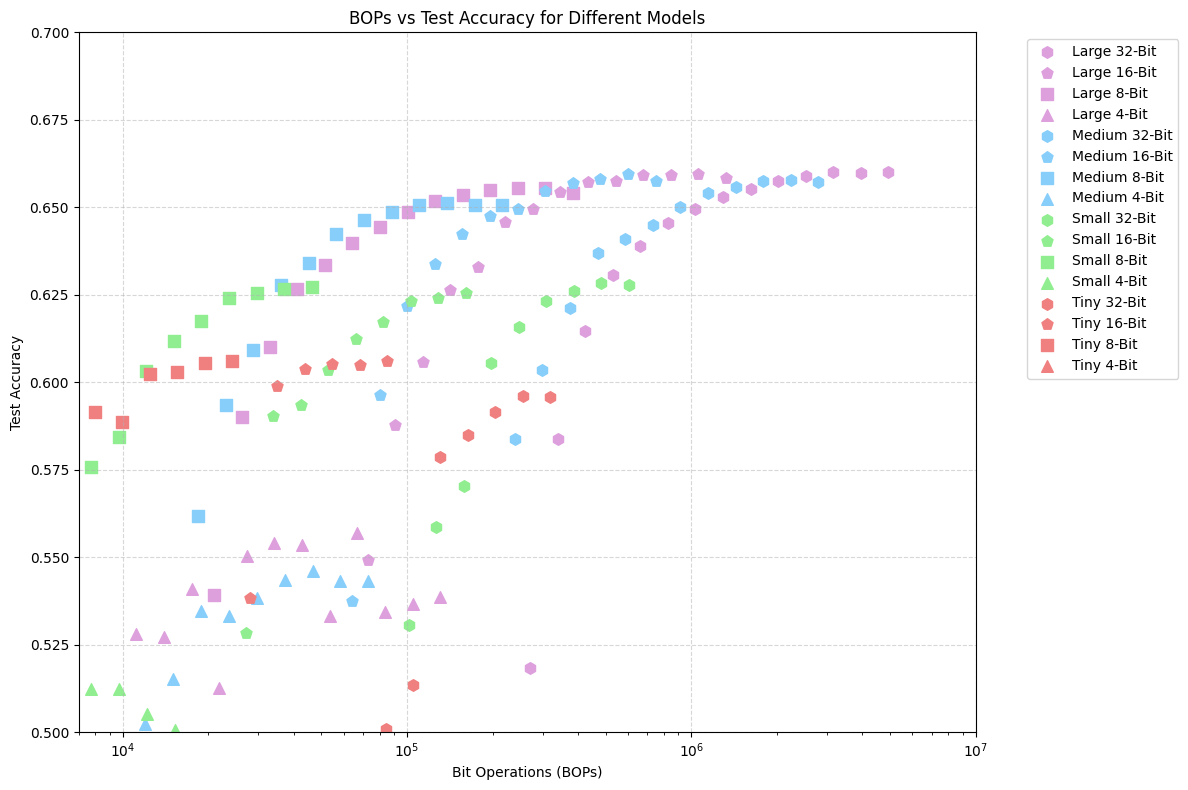

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def plot_bops_vs_accuracy(data, output_folder='./plots'):
    plt.figure(figsize=(12, 8))
    
    # Define the order of models from smallest to largest
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }

    # Define shapes for different bit widths
    bit_width_shapes = {
        4: 'triangle',
        8: 'square',
        16: 'pentagon',
        32: 'hexagon'
    }

    for full_model_name, model_data in data.items():
        # Extract model size and bit width from the full model name
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model", full_model_name)
        if match:
            model_size, bit_width = match.groups()
            bit_width = int(bit_width)

            if model_size in model_order:
                model_name = f'{model_size} {bit_width}-Bit'
                
                # Use the base color for the model size
                color = color_families[model_size]
                
                # Use shape based on bit width
                shape = bit_width_shapes[bit_width]
                print(f"Model: {model_name}, Shape: {shape}, Color: {color}")
                
                if shape == 'triangle':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='^', color=color, s=70)
                elif shape == 'square':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='s', color=color, s=70)
                elif shape == 'pentagon':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='p', color=color, s=70)
                elif shape == 'hexagon':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='h', color=color, s=70)

    plt.xscale('log') 
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="major", ls="--", alpha=0.5)
    plt.xlim(0.7e4, 1e7)
    plt.ylim(0.5, 0.7)
    
    plt.tight_layout()
    plt.savefig(f'{output_folder}/BOPs_vs_Accuracy_shapes.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_folder}/BOPs_vs_Accuracy_shapes.png")
    
    plt.show()
extracted_data = extract_data(file_path)
plot_bops_vs_accuracy(extracted_data)